In [1]:
from PID import *
import matplotlib.pyplot as plt 
import optuna
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, GRU, Input
import numpy as np 
import openpyxl
from tqdm.notebook import tqdm
from openpyxl import Workbook, load_workbook

In [2]:
class Scaler:
    def __init__(self):
        self.min_vals: list[float] = None
        self.max_vals: list[float] = None

    def fit(self, X_train):
        
        self.min_vals = np.empty(X_train.shape[-1])
        self.max_vals = np.empty(X_train.shape[-1])
        
        for s in range(X_train.shape[-1]):
            self.min_vals[s] = np.min(X_train[:,:,s])
            self.max_vals[s] = np.max(X_train[:,:,s])
            
        return

    def transform(self, X):
        try:
            X_copy = np.copy(X)
            for s in range(X_copy.shape[-1]):
                X_copy[:,:,s] = (X[:,:,s] - self.min_vals[s]) / (self.max_vals[s] - self.min_vals[s])
        except:
            raise Execption("Not Fited!!!")
            
        return X_copy

    def __str__(self):
        return f"min_vals:{self.min_vals}\nmax_vals:{self.max_vals}"

    def __call__(self,X):
        return self.transform(X) 


        
def data_to_X_Y(data, window_size=2):
    
    x = []
    y = []
    
    for i in range(len(data) - window_size):
        row = [r for r in data[i:i+window_size]]  
        x.append(row)
        label = data[i+window_size][-1]
        y.append(label)
    return np.array(x), np.array(y)
        
def create_model(params: dict):
    """
    Function that automates the creation of a model based
    on the params input
    """
    
    n = params["nhidden"]
    fun1 = params["activation1"]
    l1 = params["l1"]
    l2 = params["l2"]
    dropout_rate = params["dropout_rate"]
    
    model = Sequential()
    model.add(Input((None, 3)))
    model.add(GRU(n,activation=fun1, kernel_regularizer=keras.regularizers.L1L2(l1=l1, l2=l2)))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(
        loss = "mse",
        optimizer = keras.optimizers.Adam(learning_rate=0.001)
    )

    return model

def get_offline_error(k, model):
    dt = 0.5

    test = dataset_test[200:500]
    t_sim = t2[200:500]
    
    Y_off = test[:, -1]
    Y_pred = np.empty(t_sim.shape[0])
    
    Y_pred[0] = Y_off[0]
    U_off = test[:, :-1]
    
    
    Y_pred[: k + 1] = Y_off[: k + 1]
    
    for n in range(k, t_sim.shape[0] - 1):
        data_input = np.column_stack((U_off[n - k : n], Y_pred[n - k : n]))
        model_input = pre(data_input.reshape(-1, k, 3))
        Y_pred[n + 1] = float(model.predict(model_input, verbose=0)[0,0])

    score = mse(Y_off, Y_pred)
    return score

def mse(y1, y2):
    return np.mean(np.square(y1 - y2))

def tuna_obj(trial):

    # Decision variables
    n = trial.suggest_int('n_hidden', 1, 50)
    fun1 = trial.suggest_categorical("activation function", ["tanh", "linear"])
    window_size = trial.suggest_int("window_size", 1, 4)
    tuna_params = {
        "nhidden": n,
        "activation1": fun1,
        "window_size": window_size,
        "l1": trial.suggest_float("l1", 1e-9, 1e-2, log=True),
        "l2": trial.suggest_float("l2", 1e-9, 1e-2, log=True),
        "dropout_rate": trial.suggest_float("dr", 0.0, 0.5, step=.01),
    }
    
    tuna_model = create_model(tuna_params)

    x_tuna, y_tuna = data_to_X_Y(dataset_train, window_size = window_size)
    pre.fit(x_tuna)
    pid_x, pid_y = data_to_X_Y(pid11[:,1:], window_size)
    pid_x2, pid_y2 = data_to_X_Y(pid12[:,1:], window_size)
    pid_xfull = np.vstack([pid_x, pid_x2])
    pid_yfull = np.concatenate([pid_y, pid_y2])
    xN = pre(x_tuna)
    # fit model
    callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
    tuna_model.fit(xN, y_tuna, validation_split=0.25, batch_size=64, epochs=40, callbacks=[callback],verbose=0)
    final_loss = tuna_model.history.history["loss"][-1]
    final_val_loss = tuna_model.history.history["val_loss"][-1]
    test_loss = mse(tuna_model.predict(pre(pid_xfull)), pid_yfull)
    offline_score = get_offline_error(window_size, tuna_model)
    try:
        wb = load_workbook(filename)
        ws = wb.active
        ws.append(list(tuna_params.values()) + [final_loss, final_val_loss, test_loss, offline_score])
        wb.save(filename)
        wb.close()
    except:
        wb = Workbook()
        ws = wb.active
        ws.title = "GRU"
        ws.append(list(tuna_params.keys()) + ["train loss", "val loss", "test loss", "offline loss"])
        ws.append(list(tuna_params.values()) + [final_loss, final_val_loss, test_loss, offline_score])
        wb.save(filename)
        wb.close()
        
    # Exporting best model
    trial.set_user_attr('tuna_params', tuna_params)
    trial.set_user_attr('model', tuna_model)
    
    return offline_score

In [3]:
# Data Loading
print("LOADING DATA")
dataset_train = np.loadtxt("data/PID_data.csv", delimiter=",")
dataset_test = np.loadtxt("data/PID_data_test.csv", delimiter=",")

pid11 = np.loadtxt("results/PID/PID_reg.csv", delimiter=",")
pid12 = np.loadtxt("results/PID/PID_servo.csv", delimiter=",")

t = dataset_train[:,0]
t2 = dataset_test[:,0]

dt = t[1] - t[0]

dataset_train = dataset_train[:, 1:]
dataset_test = dataset_test[:, 1:]

x_train, _ = data_to_X_Y(dataset_train)

pre = Scaler()
pre.fit(x_train)

print(pre)

filename = "results/GRU/modeling.xlsx"

print("DATA LOADED")

LOADING DATA
min_vals:[7.77500000e+00 5.44125438e-03 6.05768729e+00]
max_vals:[23.325       4.96735564  9.44468317]
DATA LOADED


In [4]:
minimal_params = {
    "n_hdden":1,
    "activation function": "tanh",
    "l1":1e-9,
    "l2":1e-9,
    "dr":0.1,
    "window_size":1
}

In [5]:
import pickle 
try:
    with open("tuna_study.obj", "rb") as file:
        study = pickle.load(file)
except:
    study = optuna.create_study()
    study.enqueue_trial(minimal_params)
    
study.optimize(tuna_obj, timeout=60*15) #timeout = seconds to run

with open("tuna_study.obj", "wb") as file:
    pickle.dump(study, file)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-26 16:37:33,141] Trial 27 finished with value: 0.01640518580824816 and parameters: {'n_hidden': 24, 'activation function': 'tanh', 'window_size': 3, 'l1': 0.0001969071360761338, 'l2': 3.295071680202894e-07, 'dr': 0.44}. Best is trial 20 with value: 0.00554651896756447.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-26 16:39:09,973] Trial 28 finished with value: 0.007279144241870948 and parameters: {'n_hidden': 34, 'activation function': 'tanh', 'window_size': 4, 'l1': 4.954308708654279e-05, 'l2': 1.0277302875894866e-06, 'dr': 0.46}. Best is trial 20 with value: 0.00554651896756447.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-26 16:40:42,856] Trial 29 finished with value: 0.0698721133214506 and parameters: {'n_hidden': 35, 'activation function': 'tanh', 'window_size': 4, 'l1': 4.6309046133963904e-05, 'l2': 1.612349719343376e-05, 'dr': 0.08}. Best is trial 20 with value: 0.00554651896756447.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-26 16:42:18,652] Trial 30 finished with value: 0.004937563463144684 and parameters: {'n_hidden': 45, 'activation function': 'tanh', 'window_size': 4, 'l1': 1.0811657247330256e-06, 'l2': 1.3688564021163353e-06, 'dr': 0.15}. Best is trial 30 with value: 0.004937563463144684.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-26 16:43:53,268] Trial 31 finished with value: 0.029599555478774082 and parameters: {'n_hidden': 45, 'activation function': 'tanh', 'window_size': 4, 'l1': 8.632214722101613e-07, 'l2': 1.213804620863432e-06, 'dr': 0.14}. Best is trial 30 with value: 0.004937563463144684.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-26 16:45:29,010] Trial 32 finished with value: 0.027317708375991442 and parameters: {'n_hidden': 46, 'activation function': 'tanh', 'window_size': 4, 'l1': 1.0471172087034574e-05, 'l2': 1.0610456283377057e-05, 'dr': 0.25}. Best is trial 30 with value: 0.004937563463144684.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-26 16:47:00,537] Trial 33 finished with value: 0.37406114934096585 and parameters: {'n_hidden': 36, 'activation function': 'tanh', 'window_size': 4, 'l1': 3.35233887351799e-06, 'l2': 1.72935903209589e-06, 'dr': 0.15}. Best is trial 30 with value: 0.004937563463144684.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-26 16:48:30,539] Trial 34 finished with value: 0.007579290575687332 and parameters: {'n_hidden': 42, 'activation function': 'tanh', 'window_size': 4, 'l1': 3.2784163007920344e-07, 'l2': 3.903801849116737e-08, 'dr': 0.22}. Best is trial 30 with value: 0.004937563463144684.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2024-07-26 16:50:00,658] Trial 35 finished with value: 0.10353854098431822 and parameters: {'n_hidden': 29, 'activation function': 'tanh', 'window_size': 4, 'l1': 1.0341253419004449e-07, 'l2': 3.939985410670502e-08, 'dr': 0.1}. Best is trial 30 with value: 0.004937563463144684.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


[I 2024-07-26 16:51:42,399] Trial 36 finished with value: 0.007396387556035302 and parameters: {'n_hidden': 43, 'activation function': 'tanh', 'window_size': 4, 'l1': 3.139947723386321e-07, 'l2': 2.5199286340174156e-07, 'dr': 0.22}. Best is trial 30 with value: 0.004937563463144684.


In [6]:
# Obtaining the best model and saving it
best_trial = study.best_trial
best_model = best_trial.user_attrs['model']
best_model.save('models/best_model.keras')

# Saving its best parameters
best_params = best_trial.user_attrs['tuna_params']
with open('models/best_model_params.txt', 'w') as f:
    for key, value in best_params.items():
        f.write(f'{key}: {value}\n')

In [7]:
dt = 0.5
k = best_params["window_size"]
test = dataset_test[200:500]
#t_sim = np.arange(0, 200, dt)
t_sim = t2[200:500]

#X_off = np.zeros((t_sim.shape[0], 2))
#U_off = np.zeros((t_sim.shape[0], 2))
#Y_off = np.zeros(t_sim.shape[0])
Y_off = test[:, -1]
Y_pred = np.empty(t_sim.shape[0])

#X_off[0, :] = [Wa, Wb]
#Y_off[0] = y_f(X_off[0], x0=7.0)
Y_pred[0] = Y_off[0]
#U_off[:, :] = [u1ss, u2ss]
U_off = test[:, :-1]

#for n in range(0, t_sim.shape[0] - 1):
#    X_off[n + 1, :] = x_next(X_off[n], U_off[n], dt)
#    Y_off[n + 1] = y_f(X_off[n + 1], x0=Y_off[n])

Y_pred[: k + 1] = Y_off[: k + 1]

for n in tqdm(range(k, t_sim.shape[0] - 1)):
    data_input = np.column_stack((U_off[n - k : n], Y_pred[n - k : n]))
    model_input = pre(data_input.reshape(-1, k, 3))
    Y_pred[n + 1] = float(best_model.predict(model_input, verbose=0)[0,0])

  0%|          | 0/295 [00:00<?, ?it/s]

0.004937563463144684


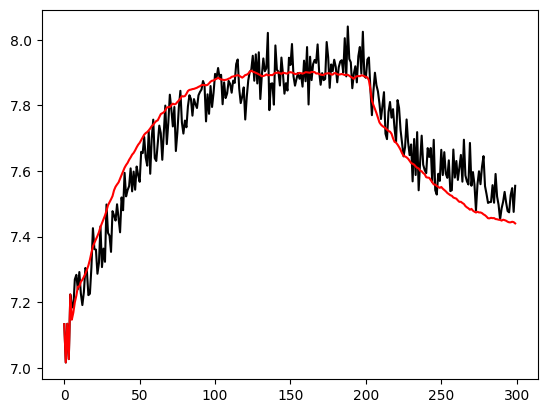

In [8]:
print(mse(Y_off, Y_pred))
plt.plot(Y_off, c='k')
plt.plot(Y_pred, c='r')

In [9]:
print(pre)

min_vals:[7.77500000e+00 5.44125438e-03 6.05768729e+00]
max_vals:[23.325       4.96735564  9.44468317]


In [10]:
with open("models/preprocessor.obj", "wb") as f:
    pickle.dump(pre, f)

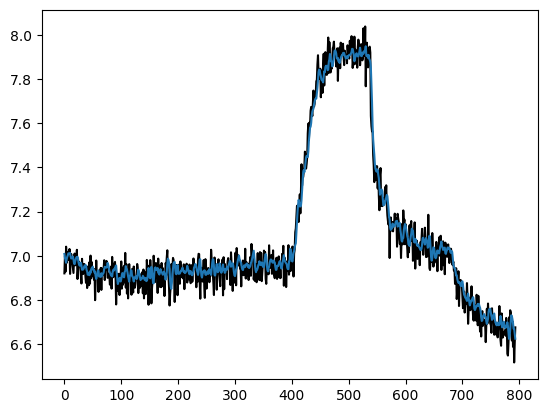

In [11]:
pid_x, pid_y = data_to_X_Y(pid11[:,1:], k)
pid_x2, pid_y2 = data_to_X_Y(pid12[:,1:], k)
pid_xfull = np.vstack([pid_x, pid_x2])
pid_yfull = np.concatenate([pid_y, pid_y2])

plt.plot(pid_yfull, c='k')
plt.plot(best_model(pre(pid_xfull)))

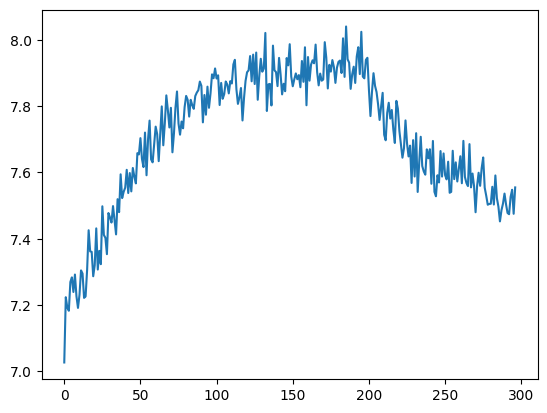

In [82]:
xtest, ytest = data_to_X_Y(test, window_size=k)

plt.plot(ytest)

In [88]:
ytest.shape

(297,)